In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime as dt 
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans  # Corrected import for k-means clustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)



In [4]:
retail = pd.read_excel('Online Retail.xlsx')


In [5]:
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [6]:
retail.shape

(541909, 8)

In [7]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
retail.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

DATA CLEANING 

In [9]:
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [10]:
retail = retail.dropna()
retail.shape

(406829, 8)

In [11]:
retail['CustomerID'] = retail['CustomerID'].astype(str)

Feature engineering

In [12]:
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Amount  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom   15.30  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom   22.00  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34  
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34

In [13]:
rfm_m = retail.groupby('CustomerID')['Amount'].sum().reset_index()
rfm_m.head()

CustomerID   Amount
0    12346.0     0.00
1    12347.0  4310.00
2    12348.0  1797.24
3    12349.0  1757.55
4    12350.0   334.40

In [14]:
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count().reset_index()
rfm_f.head()

CustomerID  InvoiceNo
0    12346.0          2
1    12347.0        182
2    12348.0         31
3    12349.0         73
4    12350.0         17

In [15]:
rfm_f.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
rfm_f.head()

CustomerID  Frequency
0    12346.0          2
1    12347.0        182
2    12348.0         31
3    12349.0         73
4    12350.0         17

In [16]:
merged_rfm = rfm_m.merge(rfm_f, on='CustomerID')
merged_rfm.head()

CustomerID   Amount  Frequency
0    12346.0     0.00          2
1    12347.0  4310.00        182
2    12348.0  1797.24         31
3    12349.0  1757.55         73
4    12350.0   334.40         17

In [17]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Amount  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom   15.30  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom   22.00  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34  
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34

In [18]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [19]:
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Amount  \
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom   15.30   
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34   
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom   22.00   
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34   
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   20.34   

               Diff  
0 373 days 04:24:00  
1 373 days 04:24:00  
2 373 days 04:24:00  
3 373 days 04:24:00  
4 373 days 04:24:00

In [20]:
rfm_p = retail.groupby('CustomerID')['Diff'].min().reset_index()
rfm_p.head()

CustomerID              Diff
0    12346.0 325 days 02:33:00
1    12347.0   1 days 20:58:00
2    12348.0  74 days 23:37:00
3    12349.0  18 days 02:59:00
4    12350.0 309 days 20:49:00

In [21]:
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

CustomerID  Diff
0    12346.0   325
1    12347.0     1
2    12348.0    74
3    12349.0    18
4    12350.0   309

In [22]:
merged_rfm.head()

CustomerID   Amount  Frequency
0    12346.0     0.00          2
1    12347.0  4310.00        182
2    12348.0  1797.24         31
3    12349.0  1757.55         73
4    12350.0   334.40         17

In [23]:
merged_rfm = merged_rfm.merge(rfm_p, on='CustomerID')

merged_rfm.rename(columns={'Diff': 'Recency'}, inplace=True)
merged_rfm.head()

CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309

Let skew our data 


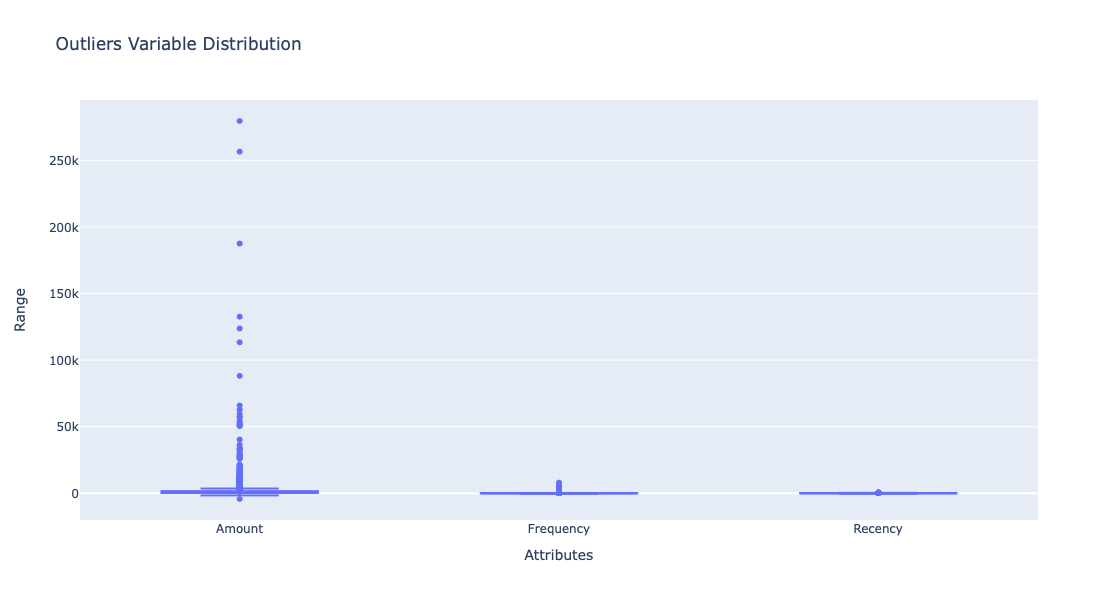

In [24]:
attributes = ['Amount', 'Frequency', 'Recency']
data = merged_rfm[attributes]

# Create a box plot with Plotly
fig = px.box(data, y=attributes, labels={'variable': 'Attributes', 'value': 'Range'},
             title="Outliers Variable Distribution")
fig.update_layout(
    xaxis=dict(title="Attributes"),
    yaxis=dict(title="Range"),
    showlegend=False,
    boxmode='group',  # Display box plots side by side
    width=800, height=600
)
fig.show()


In [25]:

Q1 = merged_rfm.Amount.quantile(0.05)
Q3 = merged_rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
merged_rfm = merged_rfm[(merged_rfm.Amount >= Q1 - 1.5*IQR) & (merged_rfm.Amount <= Q3 + 1.5*IQR)]




Q1 = merged_rfm.Recency.quantile(0.05)
Q3 = merged_rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
merged_rfm = merged_rfm[(merged_rfm.Recency >= Q1 - 1.5*IQR) & (merged_rfm.Recency <= Q3 + 1.5*IQR)]


Q1 = merged_rfm.Frequency.quantile(0.05)
Q3 = merged_rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
merged_rfm = merged_rfm[(merged_rfm.Frequency >= Q1 - 1.5*IQR) & (merged_rfm.Frequency <= Q3 + 1.5*IQR)]

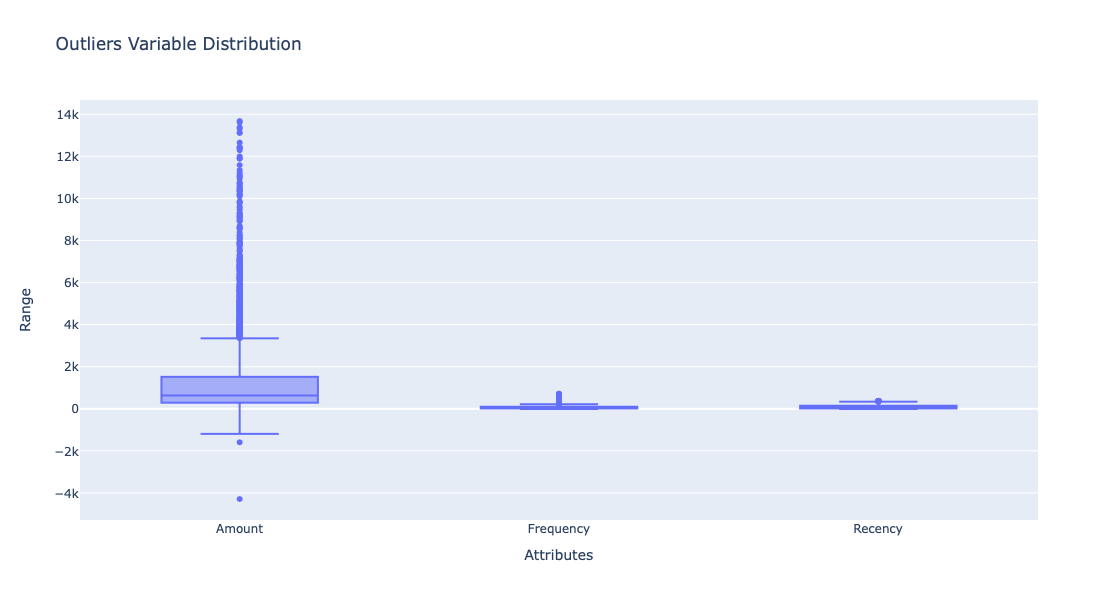

In [26]:
attributes = ['Amount', 'Frequency', 'Recency']

fig = px.box(merged_rfm, y=attributes, title="Outliers Variable Distribution", 
             labels={'variable': 'Attributes', 'value': 'Range'},
             boxmode='group', points='outliers')

fig.update_layout(
    xaxis=dict(title="Attributes", title_font=dict(size=14)),
    yaxis=dict(title="Range", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [27]:

merged_rfm = merged_rfm[['Amount', 'Frequency', 'Recency']]


scaler = StandardScaler()


rfm_df_scaled = scaler.fit_transform(merged_rfm)
rfm_df_scaled.shape

(4293, 3)

In [28]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

Amount  Frequency   Recency
0 -0.723738  -0.752888  2.301611
1  1.731617   1.042467 -0.906466
2  0.300128  -0.463636 -0.183658
3  0.277517  -0.044720 -0.738141
4 -0.533235  -0.603275  2.143188

In [29]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

For n_clusters=2, the Elbow score is 8703.493695588299
For n_clusters=3, the Elbow score is 4433.58680581154
For n_clusters=4, the Elbow score is 3360.7231568321777
For n_clusters=5, the Elbow score is 2802.926178172149
For n_clusters=6, the Elbow score is 2392.2485251696567
For n_clusters=7, the Elbow score is 2224.631714653532
For n_clusters=8, the Elbow score is 1937.8945549045598


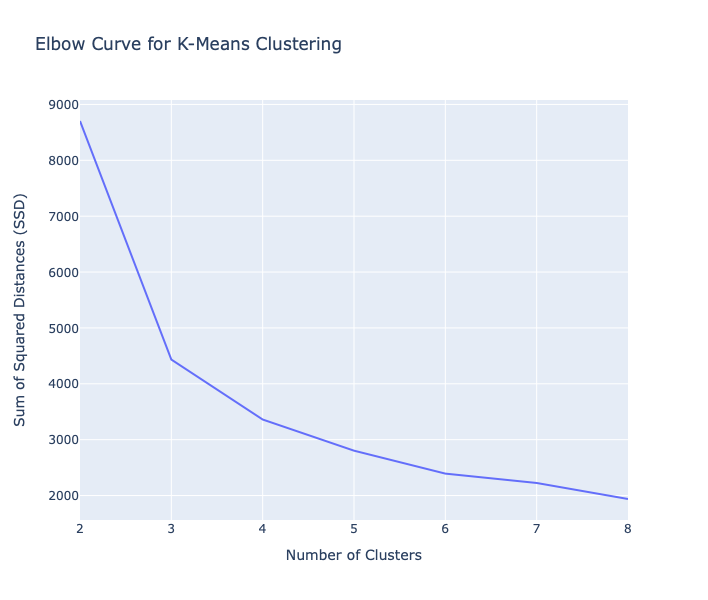

In [30]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    print("For n_clusters={0}, the Elbow score is {1}".format(num_clusters, kmeans.inertia_))

fig = px.line(x=range_n_clusters, y=ssd, 
              title="Elbow Curve for K-Means Clustering",
              labels={'x': 'Number of Clusters', 'y': 'Sum of Squared Distances (SSD)'})

fig.update_layout(
    xaxis=dict(title_font=dict(size=14)),
    yaxis=dict(title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [31]:
ssd

[8703.493695588299,
 4433.58680581154,
 3360.7231568321777,
 2802.926178172149,
 2392.2485251696567,
 2224.631714653532,
 1937.8945549045598]

In [32]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4025940739563748
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48251403049411307
For n_clusters=5, the silhouette score is 0.46481058150500315
For n_clusters=6, the silhouette score is 0.4440135975023479
For n_clusters=7, the silhouette score is 0.41481670613813887
For n_clusters=8, the silhouette score is 0.38694972471936245


In [33]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [34]:
 kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1], dtype=int32)

In [35]:
merged_rfm['Cluster_Id'] = kmeans.labels_
merged_rfm.head()

Amount  Frequency  Recency  Cluster_Id
0     0.00          2      325           2
1  4310.00        182        1           0
2  1797.24         31       74           1
3  1757.55         73       18           1
4   334.40         17      309           2

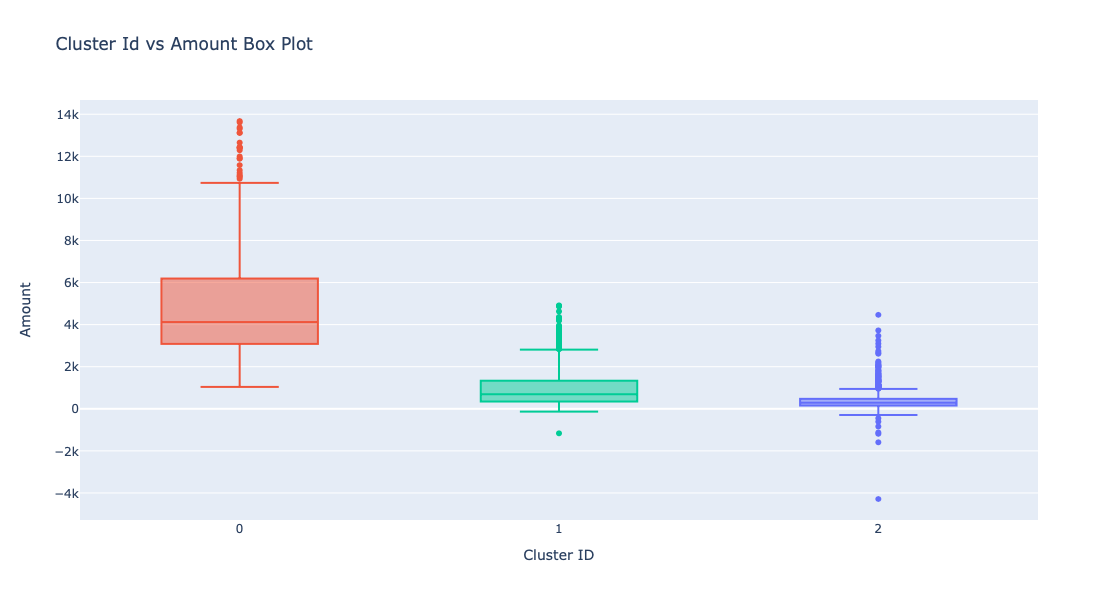

In [36]:
fig = px.box(merged_rfm, x='Cluster_Id', y='Amount',
             title="Cluster Id vs Amount Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Amount': 'Amount'},
             color='Cluster_Id')

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Amount", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()


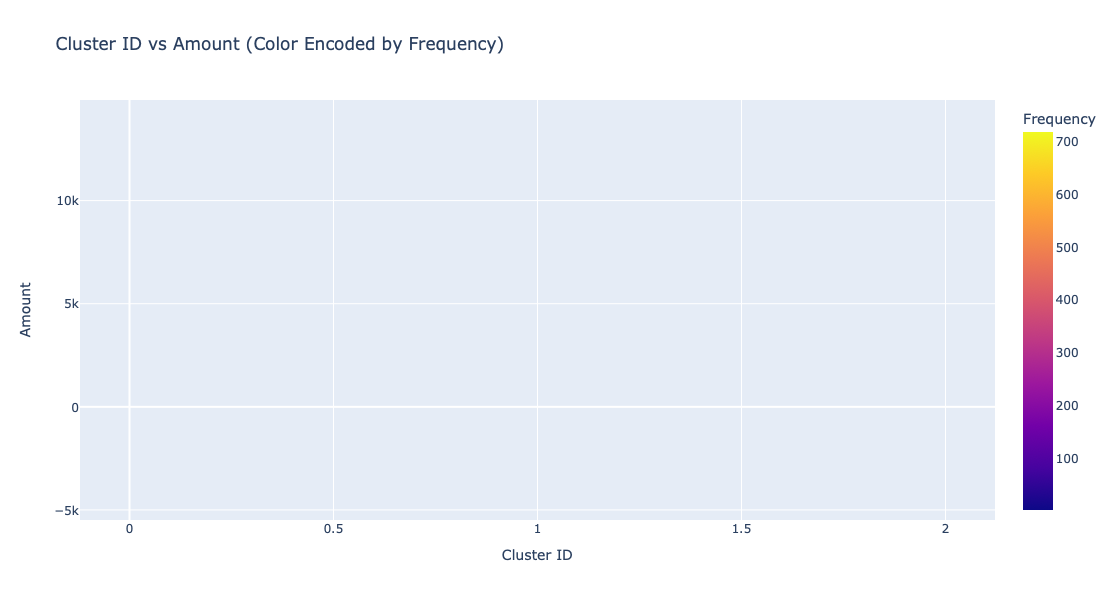

In [37]:
fig = px.scatter(merged_rfm, x='Cluster_Id', y='Amount', color='Frequency',
                 title='Cluster ID vs Amount (Color Encoded by Frequency)',
                 labels={'Cluster_Id': 'Cluster ID', 'Amount': 'Amount', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Amount", title_font=dict(size=14)),
    showlegend=True,
    width=800,
    height=600
)

fig.show()

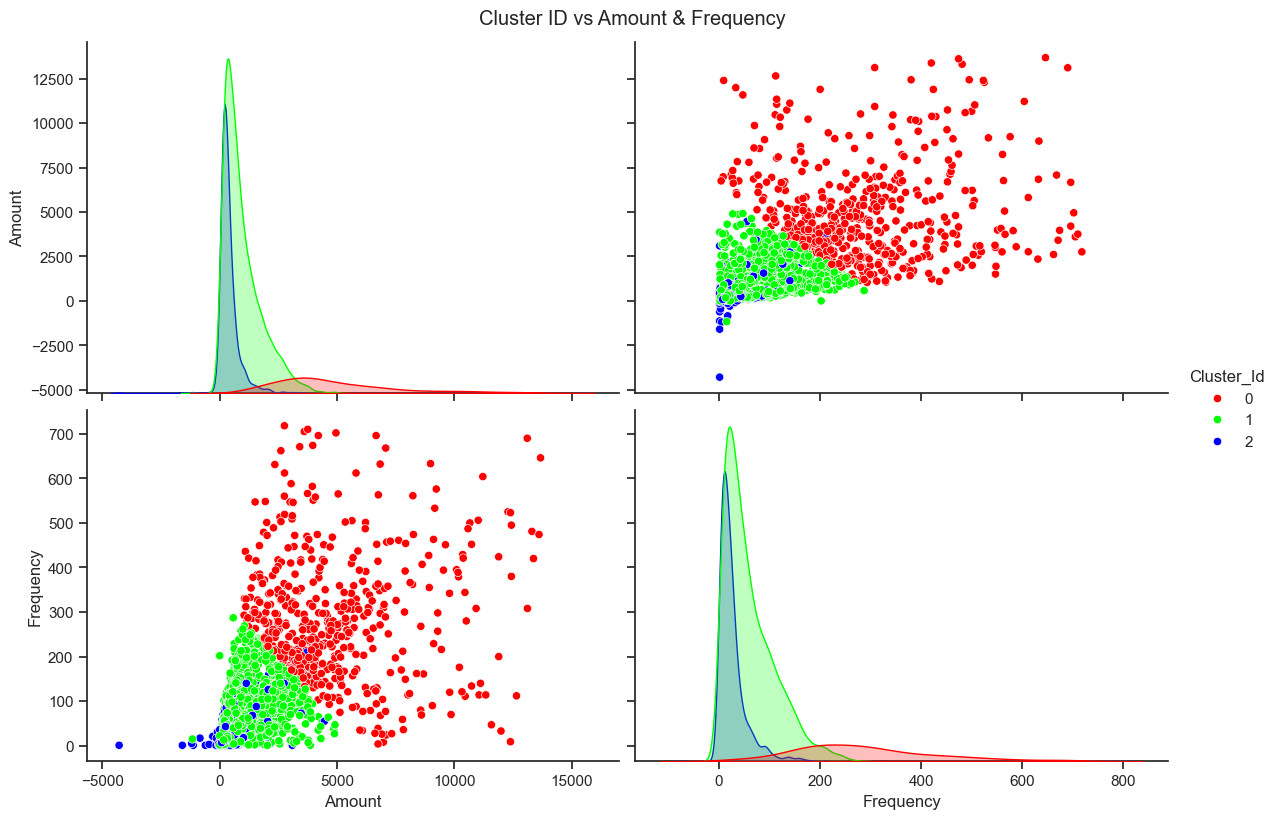

In [38]:
custom_palette = sns.color_palette(["#FF0000", "#00FF00", "#0000FF"])

sns.set(style="ticks")
sns.pairplot(merged_rfm, hue='Cluster_Id', vars=['Amount', 'Frequency'], palette=custom_palette, height=4, aspect=1.5)
plt.suptitle('Cluster ID vs Amount & Frequency', y=1.02)
plt.show()

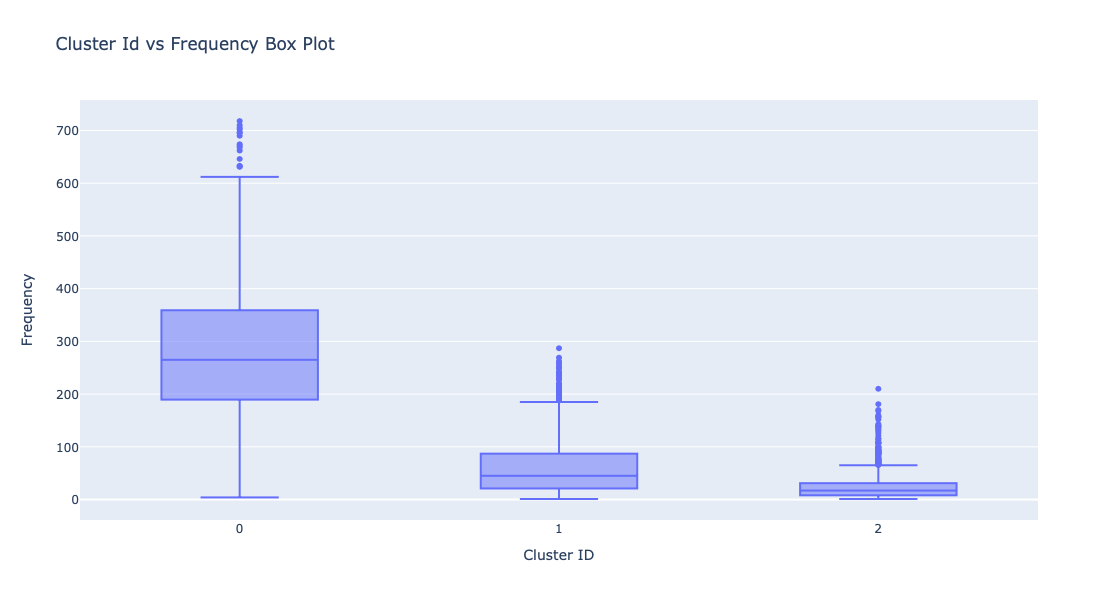

In [39]:
fig = px.box(merged_rfm, x='Cluster_Id', y='Frequency',
             title="Cluster Id vs Frequency Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

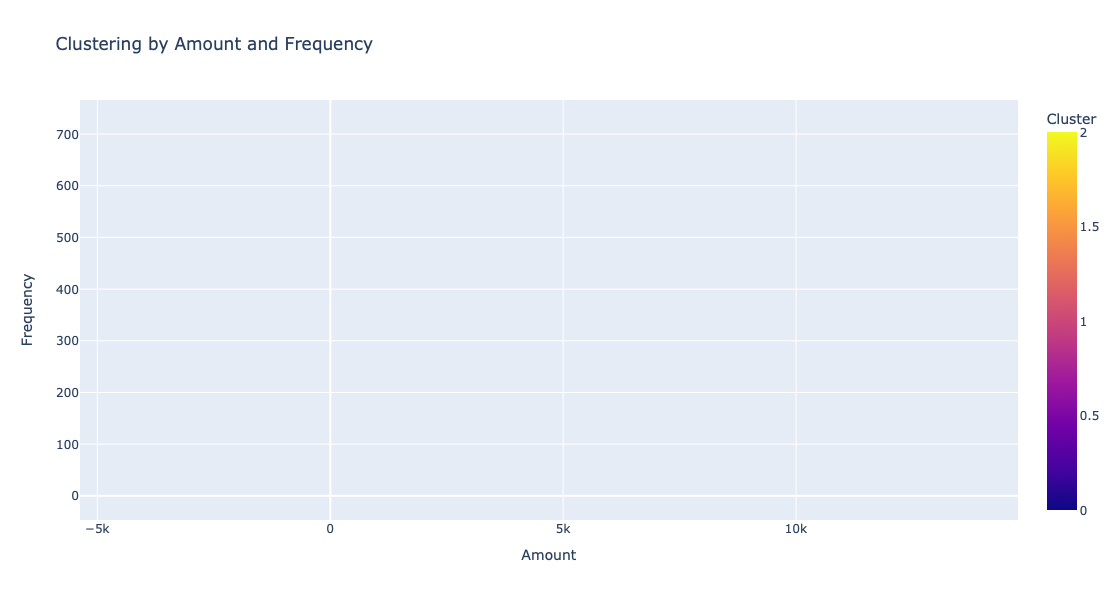

In [40]:
data_for_clustering = merged_rfm[['Amount', 'Frequency']]


n_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
merged_rfm['Cluster_2D'] = kmeans.fit_predict(data_for_clustering)

# Create a scatter plot with Plotly
fig = px.scatter(merged_rfm, x='Amount', y='Frequency', color='Cluster_2D',
                 title='Clustering by Amount and Frequency',
                 labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Cluster_2D': 'Cluster'})

fig.update_layout(
    xaxis=dict(title="Amount", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

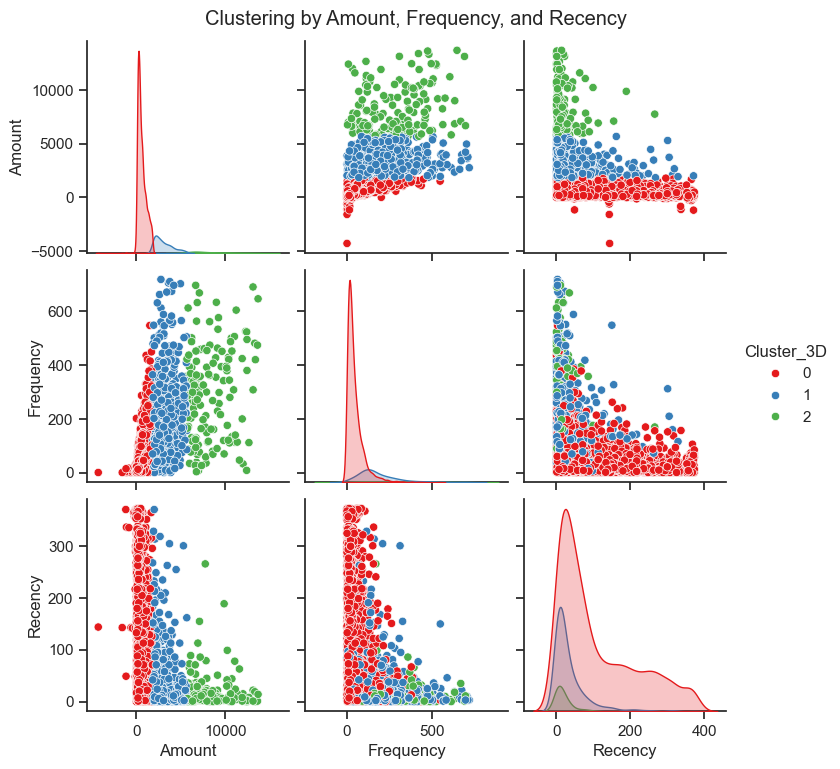

In [41]:
data_for_clustering = merged_rfm[['Amount', 'Frequency', 'Recency']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
merged_rfm['Cluster_3D'] = kmeans.fit_predict(data_for_clustering)

# Visualize the clusters (scatter plot matrix)
sns.set(style="ticks")
sns.pairplot(merged_rfm, hue='Cluster_3D', vars=['Amount', 'Frequency', 'Recency'], palette='Set1')
plt.suptitle('Clustering by Amount, Frequency, and Recency', y=1.02)
plt.show()

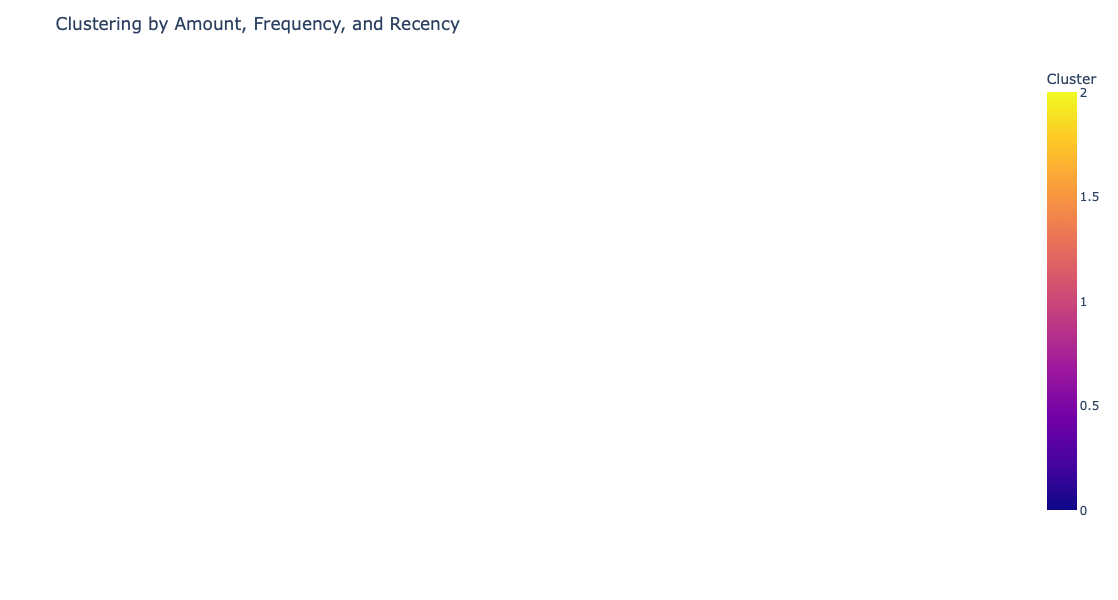

In [42]:
kmeans = KMeans(n_clusters=n_clusters)
merged_rfm['Cluster_3D'] = kmeans.fit_predict(data_for_clustering)

# Create a 3D scatter plot matrix with Plotly
fig = px.scatter_3d(merged_rfm, x='Amount', y='Frequency', z='Recency', color='Cluster_3D',
                     labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Recency': 'Recency', 'Cluster_3D': 'Cluster'})

fig.update_layout(
    scene=dict(
        xaxis_title='Amount',
        yaxis_title='Frequency',
        zaxis_title='Recency',
    ),
    title='Clustering by Amount, Frequency, and Recency',
    width=800,
    height=600
)

fig.show()

In [131]:
# Assume 'data' is your scaled or normalized dataset
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data)

# Calculate silhouette score for K-Means
silhouette_kmeans = silhouette_score(data, kmeans_labels)
print("Silhouette Score for K-Means: ", silhouette_kmeans)


Silhouette Score for K-Means:  0.9492788052852763


In [145]:
score = davies_bouldin_score(data,kmeans_labels)
print("Davies-Bouldin Score for K-Means:", score)

Davies-Bouldin Score for K-Means: 0.47570633884044966


In [135]:
linkage_methods = ['complete', 'average']
cluster_labels_dict = {}

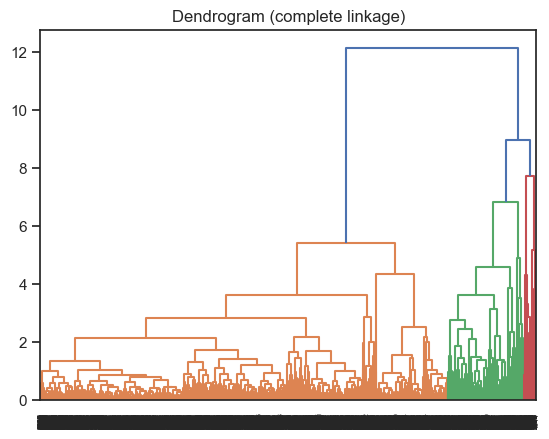

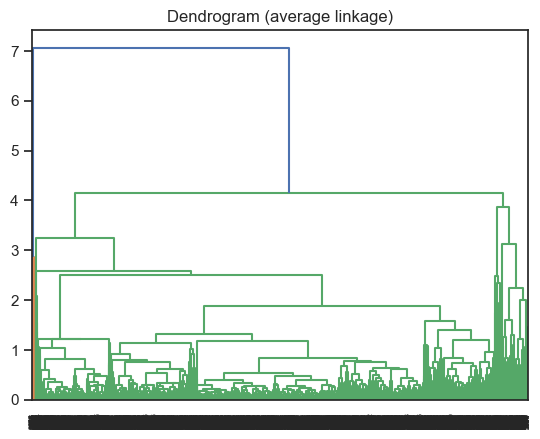

In [136]:
for method in linkage_methods:
    # Generate linkages and dendrogram
    mergings = linkage(rfm_df_scaled, method=method, metric='euclidean')
    dendrogram(mergings)
    plt.title(f'Dendrogram ({method} linkage)')
    plt.show()

In [138]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels_dict[method] = cluster_labels

In [139]:
merged_rfm[f'Clusters_{method}'] = cluster_labels

In [147]:
silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
print(f"Silhouette Score for {method} linkage:", silhouette_avg)

Silhouette Score for average linkage: 0.5812590418480046


In [142]:
from sklearn.metrics import davies_bouldin_score

In [143]:
davies_bouldin = davies_bouldin_score(rfm_df_scaled, cluster_labels)
print(f"Davies-Bouldin Score for {method} linkage:", davies_bouldin)

Davies-Bouldin Score for average linkage: 0.8498028700235696


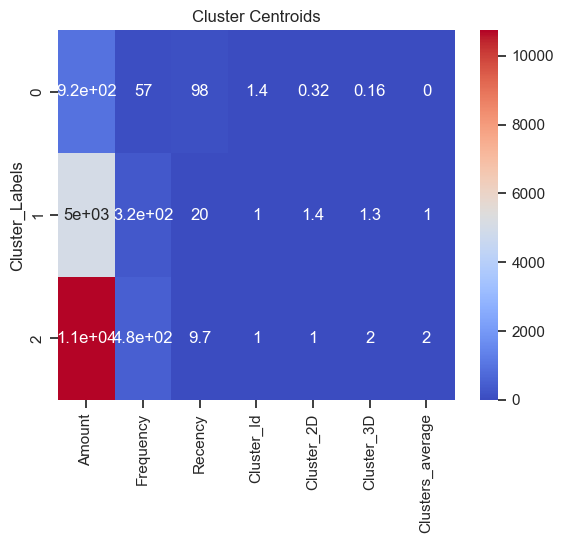

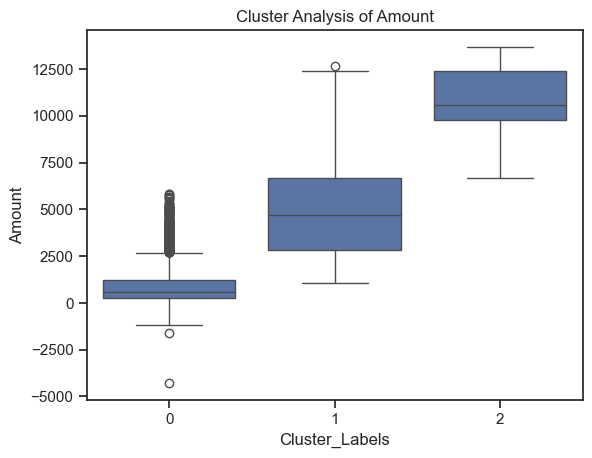

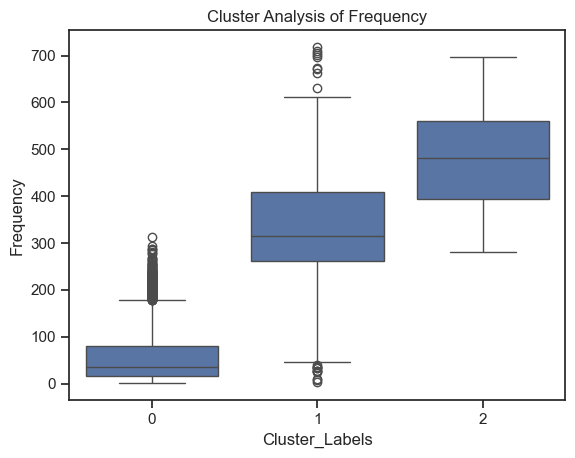

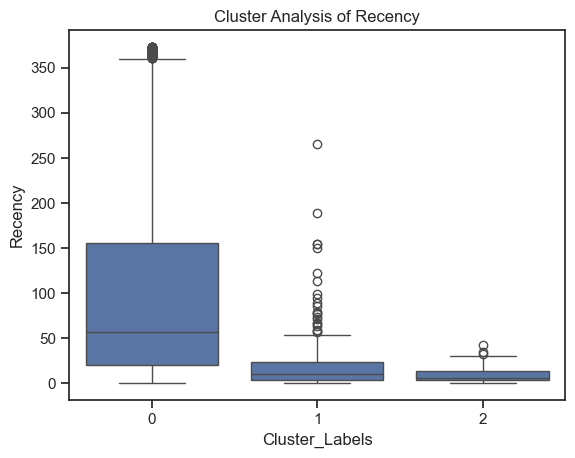

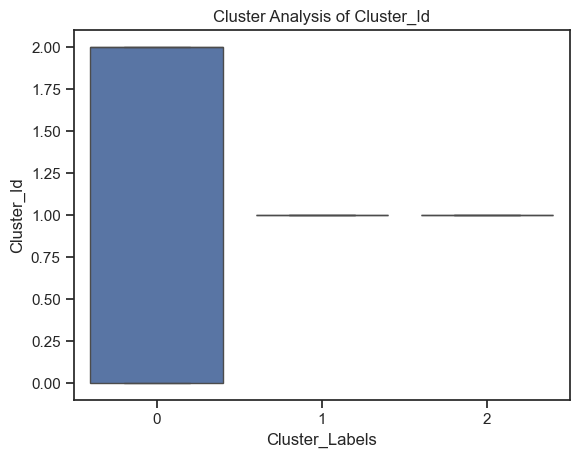

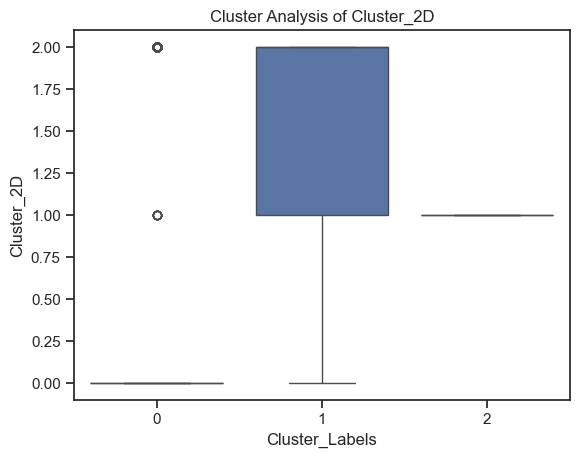

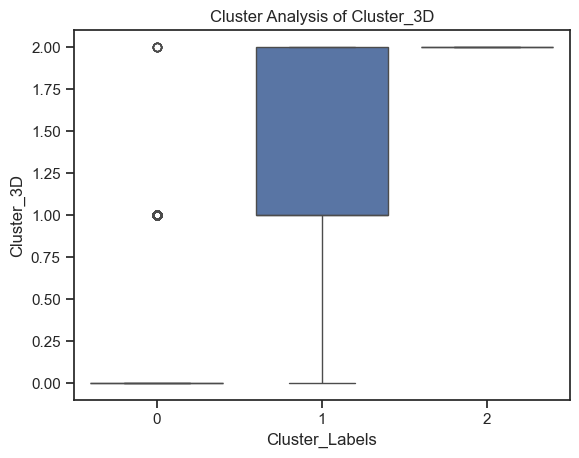

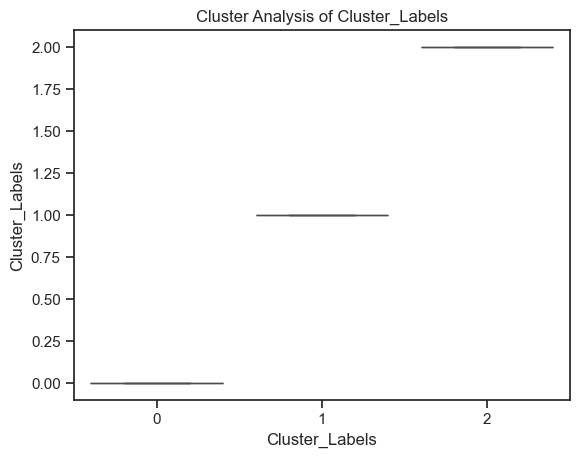

In [153]:
cluster_means = merged_rfm.groupby('Cluster_Labels').mean()

# Plotting cluster centroids
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Cluster Centroids')
plt.show()

# Box plot for visual comparison
for col in merged_rfm.columns[:-1]:  # Exclude the cluster label column
    sns.boxplot(x='Cluster_Labels', y=col, data=merged_rfm)
    plt.title(f'Cluster Analysis of {col}')
    plt.show()

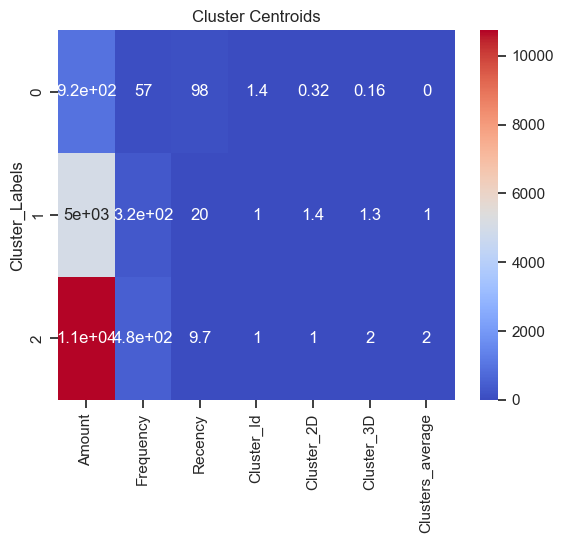

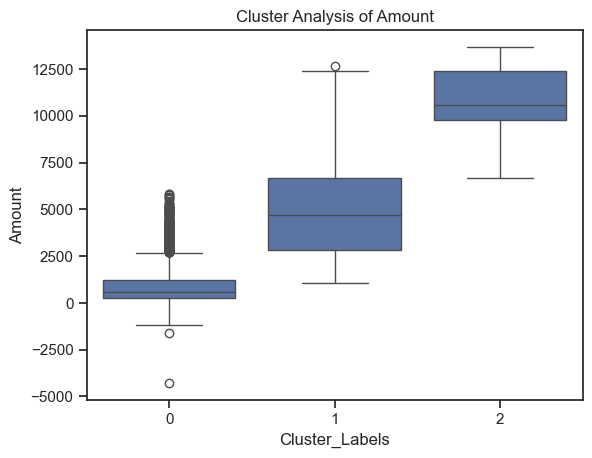

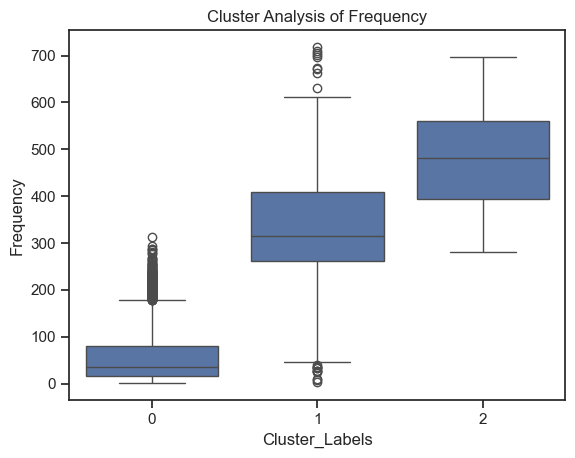

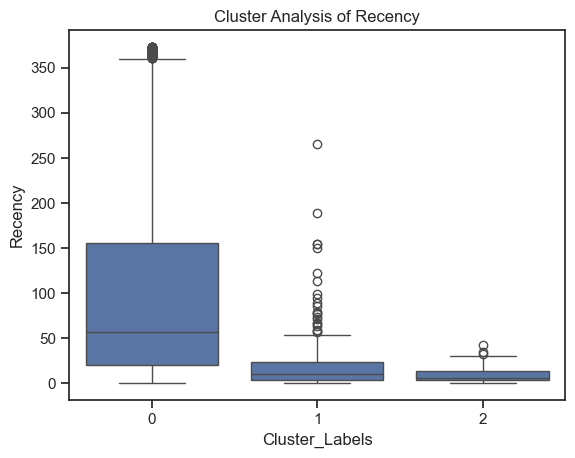

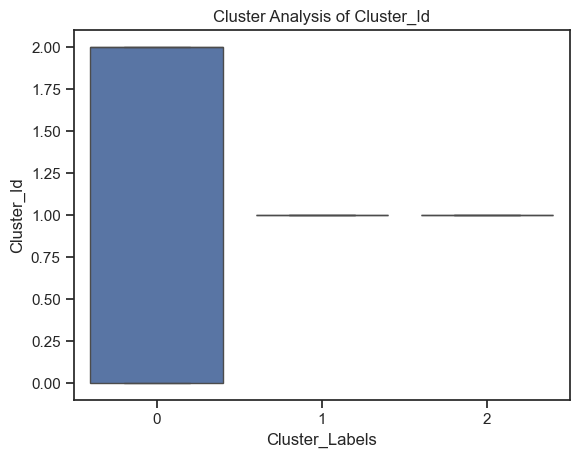

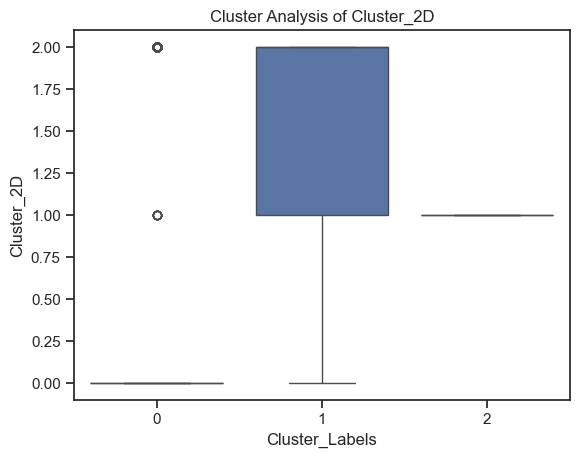

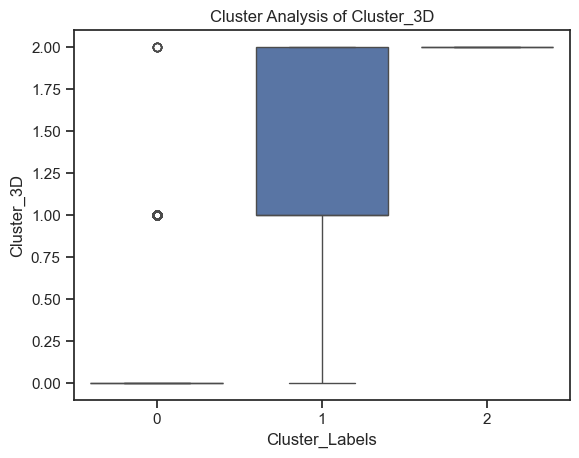

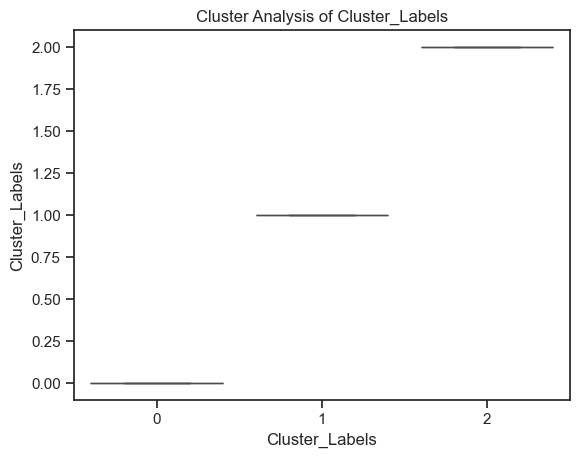

In [153]:
cluster_means = merged_rfm.groupby('Cluster_Labels').mean()

# Plotting cluster centroids
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Cluster Centroids')
plt.show()

# Box plot for visual comparison
for col in merged_rfm.columns[:-1]:  # Exclude the cluster label column
    sns.boxplot(x='Cluster_Labels', y=col, data=merged_rfm)
    plt.title(f'Cluster Analysis of {col}')
    plt.show()

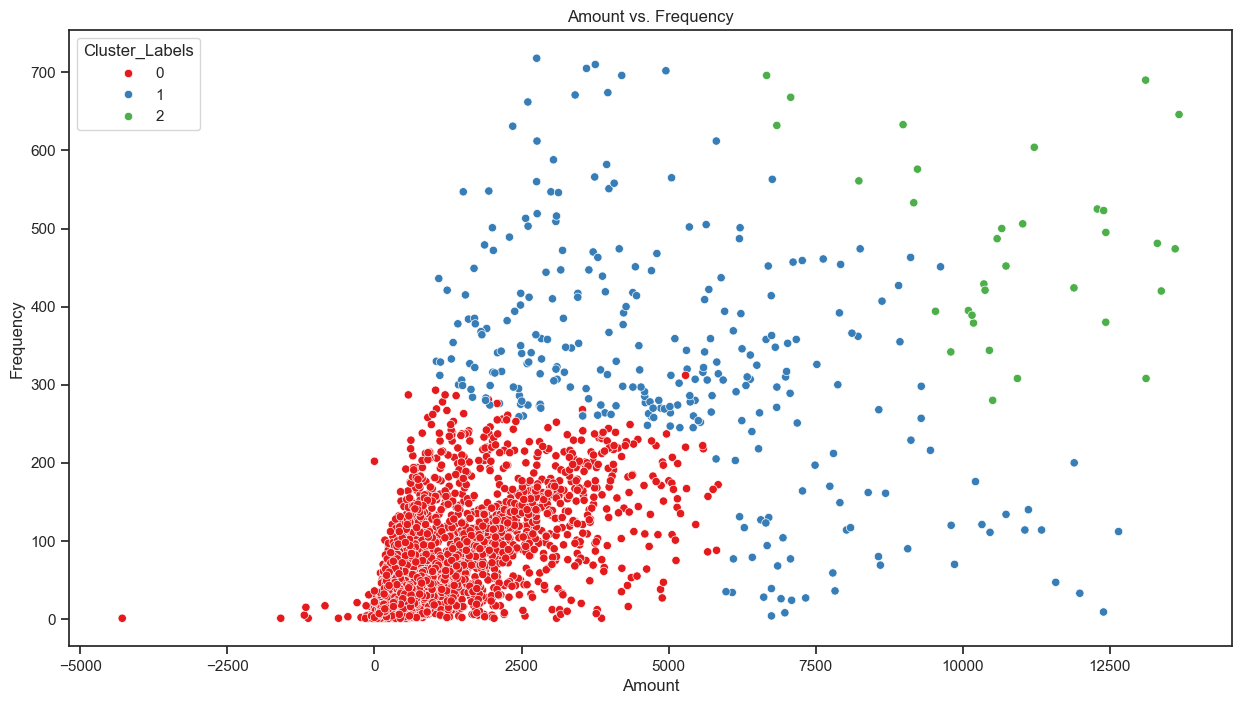

In [121]:
plt.figure(figsize=(15, 8)) 

# Amount vs. Frequency
sns.scatterplot(x='Amount', y='Frequency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Amount vs. Frequency');

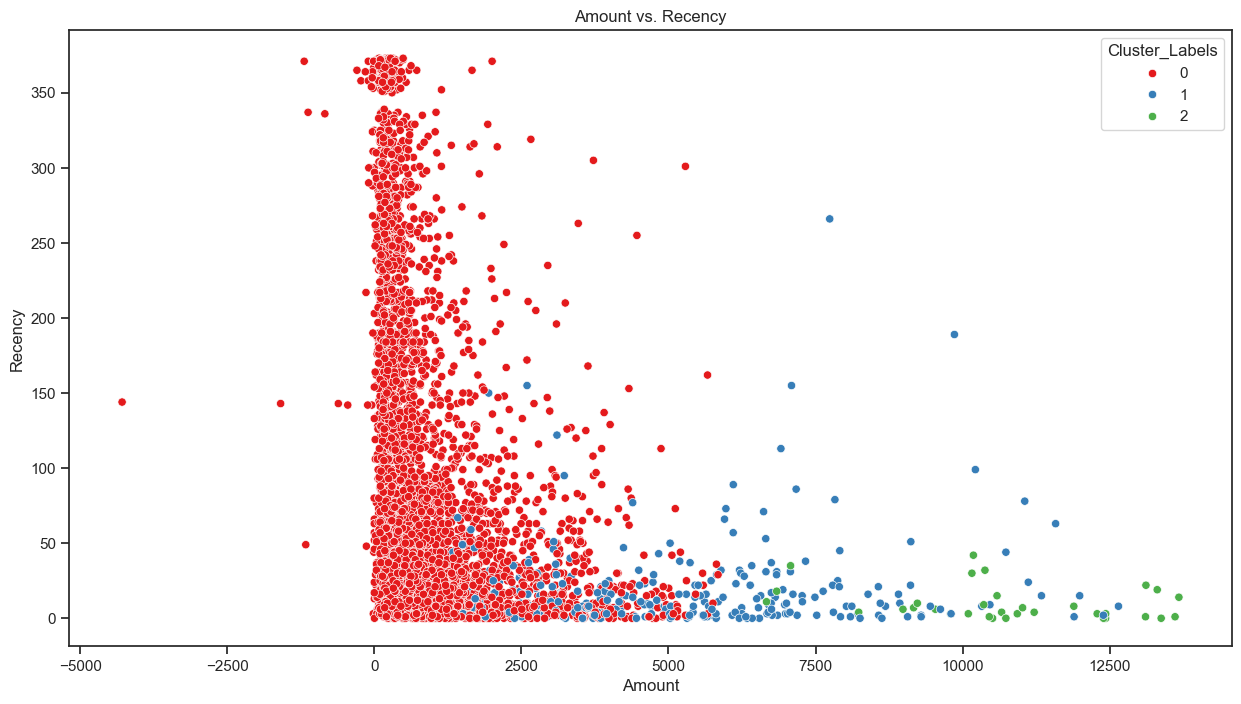

In [122]:
plt.figure(figsize=(15, 8))  

sns.scatterplot(x='Amount', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Amount vs. Recency');

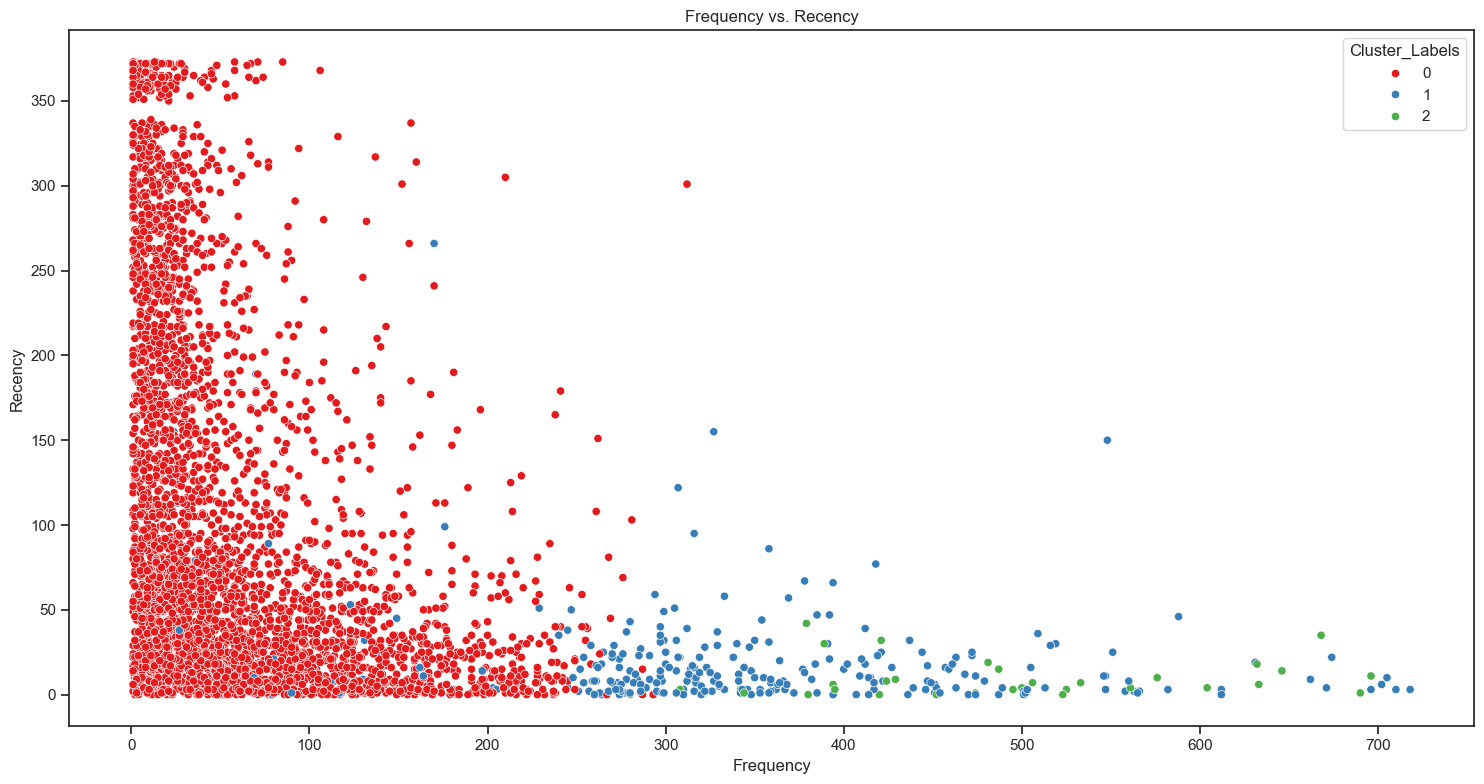

In [123]:
plt.figure(figsize=(15, 8))  
sns.scatterplot(x='Frequency', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Frequency vs. Recency')

plt.tight_layout()
plt.show()